In [83]:
!pip install rdkit-pypi --quiet

In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from rdkit import Chem
from rdkit.Chem import Descriptors, Draw, PandasTools
import math
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem.FilterCatalog import FilterCatalog, FilterCatalogParams
from tqdm.auto import tqdm

# Lipinski Filtering

In [85]:
def calculate_ro5_properties(smiles):
    """
    Test if input molecule (SMILES) fulfills Lipinski's rule of five.

    Parameters
    ----------
    smiles : str
        SMILES for a molecule.

    Returns
    -------
    pandas.Series
        Molecular weight, number of hydrogen bond acceptors/donor and logP value
        and Lipinski's rule of five compliance for input molecule.
    """
    # RDKit molecule from SMILES
    molecule = Chem.MolFromSmiles(smiles)
    # Calculate Ro5-relevant chemical properties
    molecular_weight = Descriptors.ExactMolWt(molecule)
    n_hba = Descriptors.NumHAcceptors(molecule)
    n_hbd = Descriptors.NumHDonors(molecule)
    logp = Descriptors.MolLogP(molecule)
    # Check if Ro5 conditions fulfilled
    conditions = [molecular_weight <= 500, n_hba <= 10, n_hbd <= 5, logp <= 5]
    ro5_fulfilled = sum(conditions) >= 3
    # Return True if no more than one out of four conditions is violated
    return pd.Series(
        [molecular_weight, n_hba, n_hbd, logp, ro5_fulfilled],
        index=["molecular_weight", "n_hba", "n_hbd", "logp", "ro5_fulfilled"],
    )

In [86]:
molecules = pd.read_csv("/content/sample_data/active_compounds.csv", index_col=0)
print(molecules.shape)
molecules.head()

(2048, 4)


,molecule_chembl_id,IC50,smiles,pIC50
0,CHEMBL323090,0.01,COc1ccc(S(=O)(=O)N(CC(=O)NCC2CCCCC2)C(CCSCc2cc...,11.000000
1,CHEMBL2064547,0.03,COc1ccc(S(=O)(=O)N(Cc2cn(CCF)nn2)[C@@H](C(=O)N...,10.522879
2,CHEMBL2064549,0.05,COc1ccc(S(=O)(=O)N(Cc2cn(CCOCCOCCOCCF)nn2)[C@@...,10.301030
3,CHEMBL2064548,0.06,COc1ccc(S(=O)(=O)N(Cc2cn(CCOCCOCCOCCOS(=O)(=O)...,10.221849
4,CHEMBL2425941,0.07,CC(C)[C@H](C(=O)NO)N(CC#N)S(=O)(=O)c1ccc(OCCF)cc1,10.154902


In [87]:
ro5_properties = molecules["smiles"].apply(calculate_ro5_properties)
ro5_properties.head()

,molecular_weight,n_hba,n_hbd,logp,ro5_fulfilled
0,563.212378,7,3,3.57990,True
1,429.148218,8,2,0.97710,True
2,561.226862,11,2,1.02690,False
3,713.240049,14,2,1.77132,False
4,373.110770,6,2,1.07918,True


In [88]:
molecules = pd.concat([molecules, ro5_properties], axis=1)
molecules.head()

,molecule_chembl_id,IC50,smiles,pIC50,molecular_weight,n_hba,n_hbd,logp,ro5_fulfilled
0,CHEMBL323090,0.01,COc1ccc(S(=O)(=O)N(CC(=O)NCC2CCCCC2)C(CCSCc2cc...,11.000000,563.212378,7,3,3.57990,True
1,CHEMBL2064547,0.03,COc1ccc(S(=O)(=O)N(Cc2cn(CCF)nn2)[C@@H](C(=O)N...,10.522879,429.148218,8,2,0.97710,True
2,CHEMBL2064549,0.05,COc1ccc(S(=O)(=O)N(Cc2cn(CCOCCOCCOCCF)nn2)[C@@...,10.301030,561.226862,11,2,1.02690,False
3,CHEMBL2064548,0.06,COc1ccc(S(=O)(=O)N(Cc2cn(CCOCCOCCOCCOS(=O)(=O)...,10.221849,713.240049,14,2,1.77132,False
4,CHEMBL2425941,0.07,CC(C)[C@H](C(=O)NO)N(CC#N)S(=O)(=O)c1ccc(OCCF)cc1,10.154902,373.110770,6,2,1.07918,True


In [89]:
# Note that the column "ro5_fulfilled" contains boolean values.
# Thus, we can use the column values directly to subset data.
# Note that ~ negates boolean values.
molecules_ro5_fulfilled = molecules[molecules["ro5_fulfilled"]]
molecules_ro5_violated = molecules[~molecules["ro5_fulfilled"]]

print(f"# compounds in unfiltered data set: {molecules.shape[0]}")
print(f"# compounds in filtered data set: {molecules_ro5_fulfilled.shape[0]}")
print(f"# compounds not compliant with the Ro5: {molecules_ro5_violated.shape[0]}")

# compounds in unfiltered data set: 2048
# compounds in filtered data set: 1863
# compounds not compliant with the Ro5: 185


In [90]:
molecules.to_csv('/content/sample_data/ro5_properties.csv', index=True)

In [91]:
#This will save filtered data
molecules_ro5_fulfilled.to_csv('/content/sample_data/ro5_properties_filtered.csv')
molecules_ro5_fulfilled.head()

,molecule_chembl_id,IC50,smiles,pIC50,molecular_weight,n_hba,n_hbd,logp,ro5_fulfilled
0,CHEMBL323090,0.010,COc1ccc(S(=O)(=O)N(CC(=O)NCC2CCCCC2)C(CCSCc2cc...,11.000000,563.212378,7,3,3.57990,True
1,CHEMBL2064547,0.030,COc1ccc(S(=O)(=O)N(Cc2cn(CCF)nn2)[C@@H](C(=O)N...,10.522879,429.148218,8,2,0.97710,True
4,CHEMBL2425941,0.070,CC(C)[C@H](C(=O)NO)N(CC#N)S(=O)(=O)c1ccc(OCCF)cc1,10.154902,373.110770,6,2,1.07918,True
5,CHEMBL2425947,0.070,COc1ccc(S(=O)(=O)N(CCn2cc(CCCF)nn2)[C@@H](C(=O...,10.154902,457.179518,8,2,1.40970,True
6,CHEMBL75164,0.092,O=CN(O)C(CS(=O)(=O)c1ccc(Oc2ccc(OC(F)(F)F)cc2)...,10.036212,465.070522,8,3,1.72060,True


## Radar Graph Generation

In [92]:
def calculate_mean_std(dataframe):
    """
    Calculate the mean and standard deviation of a dataset.

    Parameters
    ----------
    dataframe : pd.DataFrame
        Properties (columns) for a set of items (rows).

    Returns
    -------
    pd.DataFrame
        Mean and standard deviation (columns) for different properties (rows).
    """
    # Generate descriptive statistics for property columns
    stats = dataframe.describe()
    # Transpose DataFrame (statistical measures = columns)
    stats = stats.T
    # Select mean and standard deviation
    stats = stats[["mean", "std"]]
    return stats

In [93]:
molecules_ro5_fulfilled_stats = calculate_mean_std(
    molecules_ro5_fulfilled[["molecular_weight", "n_hba", "n_hbd", "logp"]]
)
molecules_ro5_fulfilled_stats

,mean,std
molecular_weight,427.756540,91.865418
n_hba,5.555556,1.737623
n_hbd,2.348363,0.999708
logp,2.683092,1.340185


In [94]:
molecules_ro5_violated_stats = calculate_mean_std(
    molecules_ro5_violated[["molecular_weight", "n_hba", "n_hbd", "logp"]]
)
molecules_ro5_violated_stats

,mean,std
molecular_weight,708.272835,200.645179
n_hba,9.037838,4.168160
n_hbd,3.827027,3.063162
logp,4.894673,2.511020


In [95]:
def _scale_by_thresholds(stats, thresholds, scaled_threshold):
    """
    Scale values for different properties that have each an individually defined threshold.

    Parameters
    ----------
    stats : pd.DataFrame
        Dataframe with "mean" and "std" (columns) for each physicochemical property (rows).
    thresholds : dict of str: int
        Thresholds defined for each property.
    scaled_threshold : int or float
        Scaled thresholds across all properties.

    Returns
    -------
    pd.DataFrame
        DataFrame with scaled means and standard deviations for each physiochemical property.
    """
    # Raise error if scaling keys and data_stats indicies are not matching
    for property_name in stats.index:
        if property_name not in thresholds.keys():
            raise KeyError(f"Add property '{property_name}' to scaling variable.")
    # Scale property data
    stats_scaled = stats.apply(lambda x: x / thresholds[x.name] * scaled_threshold, axis=1)
    return stats_scaled


def _define_radial_axes_angles(n_axes):
    """Define angles (radians) for radial (x-)axes depending on the number of axes."""
    x_angles = [i / float(n_axes) * 2 * math.pi for i in range(n_axes)]
    x_angles += x_angles[:1]
    return x_angles

def plot_radar(
    y,
    thresholds,
    scaled_threshold,
    properties_labels,
    y_max=None,
    output_path=None,
):
    """
    Plot a radar chart based on the mean and standard deviation of a data set's properties.

    Parameters
    ----------
    y : pd.DataFrame
        Dataframe with "mean" and "std" (columns) for each physicochemical property (rows).
    thresholds : dict of str: int
        Thresholds defined for each property.
    scaled_threshold : int or float
        Scaled thresholds across all properties.
    properties_labels : list of str
        List of property names to be used as labels in the plot.
    y_max : None or int or float
        Set maximum y value. If None, let matplotlib decide.
    output_path : None or pathlib.Path
        If not None, save plot to file.
    """

    # Define radial x-axes angles -- uses our helper function!
    x = _define_radial_axes_angles(len(y))
    # Scale y-axis values with respect to a defined threshold -- uses our helper function!
    y = _scale_by_thresholds(y, thresholds, scaled_threshold)
    # Since our chart will be circular we append the first value of each property to the end
    y = pd.concat([y, y.head(1)])

    # Set figure and subplot axis
    plt.figure(figsize=(6, 6))
    ax = plt.subplot(111, polar=True)

    # Plot data
    ax.fill(x, [scaled_threshold] * len(x), "cornflowerblue", alpha=0.2)
    ax.plot(x, y["mean"], "b", lw=3, ls="-")
    ax.plot(x, y["mean"] + y["std"], "orange", lw=2, ls="--")
    ax.plot(x, y["mean"] - y["std"], "orange", lw=2, ls="-.")

    # From here on, we only do plot cosmetics
    # Set 0° to 12 o'clock
    ax.set_theta_offset(math.pi / 2)
    # Set clockwise rotation
    ax.set_theta_direction(-1)

    # Set y-labels next to 180° radius axis
    ax.set_rlabel_position(180)
    # Set number of radial axes' ticks and remove labels
    plt.xticks(x, [])
    # Get maximal y-ticks value
    if not y_max:
        y_max = int(ax.get_yticks()[-1])
    # Set axes limits
    plt.ylim(0, y_max)
    # Set number and labels of y axis ticks
    plt.yticks(
        range(1, y_max),
        ["5" if i == scaled_threshold else "" for i in range(1, y_max)],
        fontsize=16,
    )

    # Draw ytick labels to make sure they fit properly
    # Note that we use [:1] to exclude the last element which equals the first element (not needed here)
    for i, (angle, label) in enumerate(zip(x[:-1], properties_labels)):
        if angle == 0:
            ha = "center"
        elif 0 < angle < math.pi:
            ha = "left"
        elif angle == math.pi:
            ha = "center"
        else:
            ha = "right"
        ax.text(
            x=angle,
            y=y_max + 1,
            s=label,
            size=16,
            horizontalalignment=ha,
            verticalalignment="center",
        )

    # Add legend relative to top-left plot
    labels = ("mean", "mean + std", "mean - std", "rule of five area")
    ax.legend(labels, loc=(1.1, 0.7), labelspacing=0.3, fontsize=16)

    # Save plot - use bbox_inches to include text boxes
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches="tight", transparent=True)

    plt.show()


In [96]:
thresholds = {"molecular_weight": 500, "n_hba": 10, "n_hbd": 5, "logp": 5}
scaled_threshold = 5
properties_labels = [
    "Molecular weight (Da) / 100",
    "# HBA / 2",
    "# HBD",
    "LogP",
]
y_max = 8

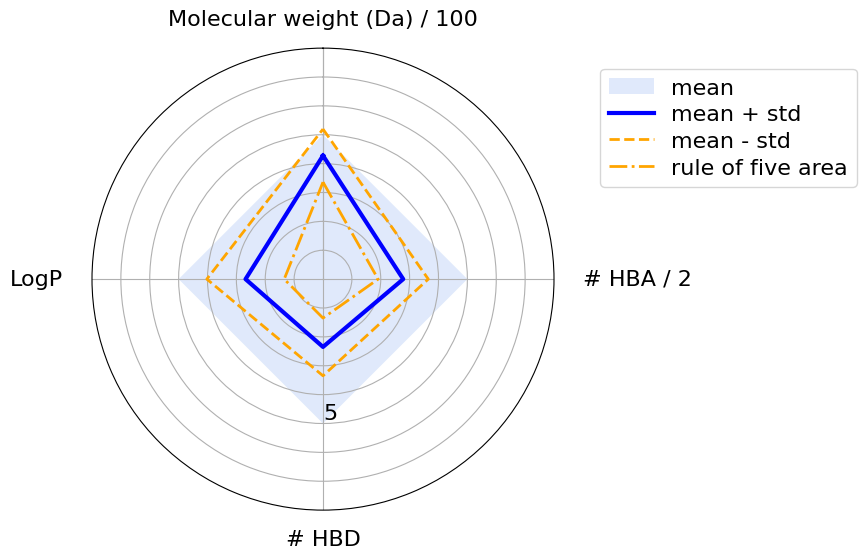

In [97]:
plot_radar(
    molecules_ro5_fulfilled_stats,
    thresholds,
    scaled_threshold,
    properties_labels,
    y_max,
)

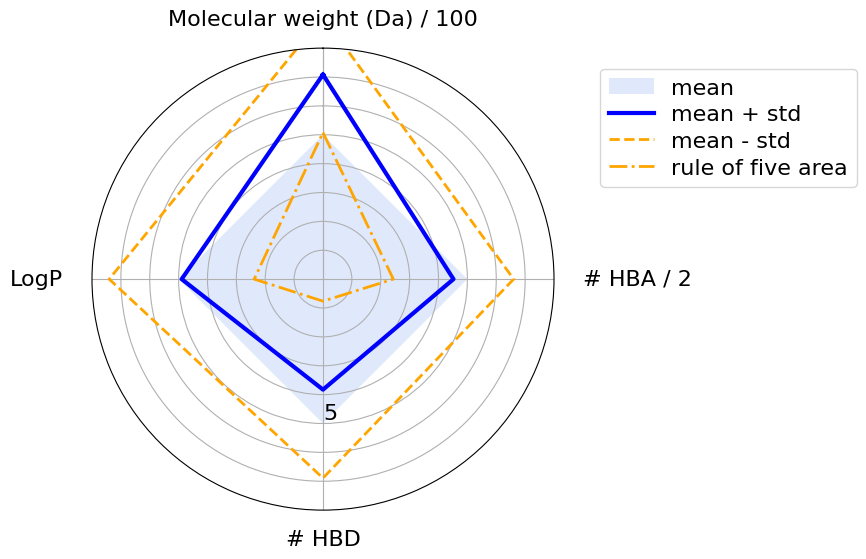

In [98]:
plot_radar(
    molecules_ro5_violated_stats,
    thresholds,
    scaled_threshold,
    properties_labels,
    y_max,
)

# Soft REOS Filtering

In [99]:
from rdkit import Chem
from rdkit.Chem import Descriptors
import pandas as pd

def calculate_soft_reos_properties(smiles):
    """
    Test if input molecule (SMILES) fulfills a softened version of the REOS criteria.

    Parameters
    ----------
    smiles : str
        SMILES for a molecule.

    Returns
    -------
    pandas.Series
        Molecular weight, number of heavy atoms, number of rotatable bonds,
        hydrogen-bond donors/acceptors, logP value, and REOS compliance for the input molecule.
    """
    # RDKit molecule from SMILES
    molecule = Chem.MolFromSmiles(smiles)

    if molecule is None:
        raise ValueError(f"Invalid SMILES string: {smiles}")

    # Calculate REOS-relevant chemical properties
    molecular_weight = Descriptors.ExactMolWt(molecule)
    n_heavy_atoms = Descriptors.HeavyAtomCount(molecule)  # Heavy atoms (non-hydrogen)
    n_rotatable_bonds = Descriptors.NumRotatableBonds(molecule)
    n_hba = Descriptors.NumHAcceptors(molecule)
    n_hbd = Descriptors.NumHDonors(molecule)
    logp = Descriptors.MolLogP(molecule)

    # Define REOS criteria (softened)
    conditions = [
        100 <= molecular_weight <= 700,  # Molecular weight between 100 and 700 g/mol
        5 <= n_heavy_atoms <= 50,        # Number of heavy atoms between 5 and 50
        0 <= n_rotatable_bonds <= 12,    # Number of rotatable bonds between 0 and 12
        0 <= n_hbd <= 5,                 # Hydrogen bond donors between 0 and 5
        0 <= n_hba <= 10,                # Hydrogen bond acceptors between 0 and 10
        -5 < logp < 7.5                  # Hydrophobicity (logP) between -5 and 7.5
    ]

    # Check if all conditions are satisfied
    reos_fulfilled = all(conditions)

    # Return the results in a pandas Series
    return pd.Series(
        [molecular_weight, n_heavy_atoms, n_rotatable_bonds, n_hba, n_hbd, logp, reos_fulfilled],
        index=["molecular_weight", "heavy_atoms", "rotatable_bonds", "n_hba", "n_hbd", "logp", "reos_fulfilled"]
    )

We will instead choose a softer filter as we are opting for higher amounts of training data.

In [100]:
# Load the data from CSV
reos_molecules = pd.read_csv("/content/sample_data/active_compounds.csv", index_col=0)

# Calculate the REOS properties
reos_properties = reos_molecules["smiles"].apply(calculate_soft_reos_properties)

# Concatenate the properties with the original DataFrame
molecules = pd.concat([reos_molecules, reos_properties], axis=1)

# Note that the column "reos_fulfilled" contains boolean values.
# Thus, we can use the column values directly to subset data.
# ~ negates boolean values.
molecules_reos_fulfilled = molecules[molecules["reos_fulfilled"]]
molecules_reos_violated = molecules[~molecules["reos_fulfilled"]]

# Print the count of compounds in the datasets
print(f"# compounds in unfiltered data set: {molecules.shape[0]}")
print(f"# compounds in filtered data set: {molecules_reos_fulfilled.shape[0]}")
print(f"# compounds not compliant with the REOS: {molecules_reos_violated.shape[0]}")

# compounds in unfiltered data set: 2048
# compounds in filtered data set: 1816
# compounds not compliant with the REOS: 232


In [102]:
#Need to add radar graphs for REOS
molecules_reos_fulfilled.to_csv("/content/sample_data/reos_properties_filtered.csv")

# Pains Filtering

In [103]:
reos_data = pd.read_csv('/content/sample_data/reos_properties_filtered.csv',
    index_col=0,
)
# Drop unnecessary information
print("Dataframe shape:", reos_data.shape)
reos_data.drop(columns=["molecular_weight", "n_hbd", "n_hba", "logp","heavy_atoms","rotatable_bonds","reos_fulfilled"], inplace=True)
reos_data.head()

Dataframe shape: (1816, 11)


,molecule_chembl_id,IC50,smiles,pIC50
1,CHEMBL2064547,0.030,COc1ccc(S(=O)(=O)N(Cc2cn(CCF)nn2)[C@@H](C(=O)N...,10.522879
4,CHEMBL2425941,0.070,CC(C)[C@H](C(=O)NO)N(CC#N)S(=O)(=O)c1ccc(OCCF)cc1,10.154902
5,CHEMBL2425947,0.070,COc1ccc(S(=O)(=O)N(CCn2cc(CCCF)nn2)[C@@H](C(=O...,10.154902
6,CHEMBL75164,0.092,O=CN(O)C(CS(=O)(=O)c1ccc(Oc2ccc(OC(F)(F)F)cc2)...,10.036212
7,CHEMBL5270698,0.092,O=CN(O)C(CS(=O)(=O)c1ccc(Oc2ccc(OC(F)(F)F)cc2)...,10.036212


Failed to patch pandas - unable to change molecule rendering


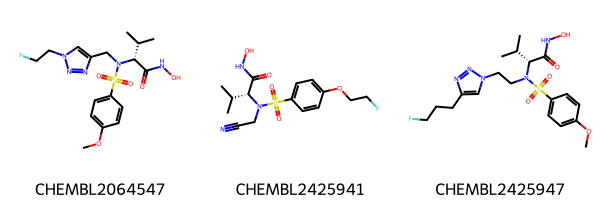

In [104]:
# Add molecule column
PandasTools.AddMoleculeColumnToFrame(reos_data, smilesCol="smiles")
# Draw first 3 molecules
Chem.Draw.MolsToGridImage(
    list(reos_data.head(3).ROMol),
    legends=list(reos_data.head(3).molecule_chembl_id),
)

In [105]:
# initialize filter
params = FilterCatalogParams()
params.AddCatalog(FilterCatalogParams.FilterCatalogs.PAINS)
catalog = FilterCatalog(params)

In [106]:
# search for PAINS
matches = []
clean = []
for index, row in tqdm(reos_data.iterrows(), total=reos_data.shape[0]):
    molecule = Chem.MolFromSmiles(row.smiles)
    entry = catalog.GetFirstMatch(molecule)  # Get the first matching PAINS
    if entry is not None:
        # store PAINS information
        matches.append(
            {
                "chembl_id": row.molecule_chembl_id,
                "rdkit_molecule": molecule,
                "pains": entry.GetDescription().capitalize(),
            }
        )
    else:
        # collect indices of molecules without PAINS
        clean.append(index)

matches = pd.DataFrame(matches)
reos_data = reos_data.loc[clean]  # keep molecules without PAINS
print(f"Number of compounds with PAINS: {len(matches)}")
print(f"Number of compounds without PAINS: {len(egfr_data)}")

  0%|          | 0/1816 [00:00<?, ?it/s]

Number of compounds with PAINS: 57
Number of compounds without PAINS: 1759


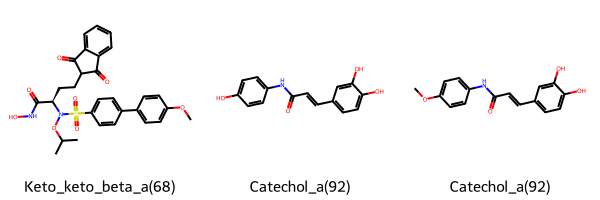

In [107]:
Chem.Draw.MolsToGridImage(
    list(matches.head(3).rdkit_molecule),
    legends=list(matches.head(3)["pains"]),
)

In [108]:
reos_data.to_csv('/content/sample_data/pains_filtered.csv')

In [109]:
# This is to use an external filter list as found here: https://github.com/Ash100/CADD_Project/blob/main/unwanted_substructures.csv
#import pandas as pd
# from rdkit import Chem
# from tqdm import tqdm
# from rdkit.Chem import Draw

# # Load the unwanted substructures from a CSV file
# substructures = pd.read_csv(DATA / "unwanted_substructures.csv", sep="\s+")

# # Convert SMARTS patterns to RDKit molecules
# substructures["rdkit_molecule"] = substructures.smarts.apply(Chem.MolFromSmarts)

# # Print the number of unwanted substructures loaded
# print("Number of unwanted substructures in collection:", len(substructures))

# # Display a few examples of the unwanted substructures
# Chem.Draw.MolsToGridImage(
#     mols=substructures.rdkit_molecule.tolist()[2:5],
#     legends=substructures.name.tolist()[2:5],
# )

# # Initialize lists to store matches and clean data (no substructure matches)
# matches = []
# clean = []

# # Search for unwanted substructures in the filtered dataframe (egfr_data)
# for index, row in tqdm(egfr_data.iterrows(), total=egfr_data.shape[0]):
#     molecule = Chem.MolFromSmiles(row.smiles)  # Convert SMILES to RDKit molecule
#     match = False  # Flag to indicate if a match is found for this molecule

#     # Iterate over each unwanted substructure and check if it matches the molecule
#     for _, substructure in substructures.iterrows():
#         if molecule.HasSubstructMatch(substructure.rdkit_molecule):  # Check for substructure match
#             matches.append(
#                 {
#                     "chembl_id": row.molecule_chembl_id,
#                     "rdkit_molecule": molecule,
#                     "substructure": substructure.rdkit_molecule,
#                     "substructure_name": substructure["name"],
#                 }
#             )
#             match = True  # Mark as matched

#     if not match:
#         clean.append(index)  # Add to clean list if no match is found

# # Convert the list of matches into a DataFrame
# matches = pd.DataFrame(matches)

# # Filter out the matched molecules from the original dataframe (egfr_data)
# egfr_data = egfr_data.loc[clean]

# # Print the number of unwanted substructure matches and clean compounds
# print(f"Number of found unwanted substructure: {len(matches)}")
# print(f"Number of compounds without unwanted substructure: {len(egfr_data)}")

# # Highlight substructures in the first 3 matches
# to_highlight = [
#     row.rdkit_molecule.GetSubstructMatch(row.substructure) for _, row in matches.head(3).iterrows()
# ]

# # Visualize the first 3 identified unwanted substructures and highlight them
# Chem.Draw.MolsToGridImage(
#     list(matches.head(3).rdkit_molecule),
#     highlightAtomLists=to_highlight,
#     legends=list(matches.head(3).substructure_name),
# )

# # Substructure statistics: Find the most frequent substructure matches
# groups = matches.groupby("substructure_name")
# group_frequencies = groups.size()  # Count the occurrences of each substructure
# group_frequencies.sort_values(ascending=False, inplace=True)  # Sort by frequency in descending order

# # Display the top 10 most frequent unwanted substructures
# group_frequencies.head(10)
